HuBMAP - Hacking the Human Vasculature

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Overview</center>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>Goal</code>: The goal of the competition is to develop a model that can segment instances of microvascular structures, such as capillaries, arterioles, and venules, in 2D PAS-stained histology images from healthy human kidney tissue slides.</p>


In [4]:
import os
import json
import shutil
from PIL import Image
from IPython.display import Image as display_image
from collections import Counter

import numpy as np
import pandas as pd
import random
import cv2
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import zipfile
import os
from IPython.display import FileLink

In [5]:
def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [6]:
# !pip install -U kaleido
# !pip install kaleido --no-index --find-links=file:///kaggle/input/libraries2/libraries/kaleido 
os.system("pip install kaleido --no-index --find-links=file:///kaggle/input/libraries2/libraries/kaleido ")


Looking in links: file:///kaggle/input/libraries2/libraries/kaleido
Processing /kaggle/input/libraries2/libraries/kaleido/kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl


0

In [7]:
class CFG:
    img_path_template: str = "/kaggle/input/hubmap-hacking-the-human-vasculature/train/{}.tif"

In [8]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

In [9]:
def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Part 1 - Data Overview</center>


<p style="font-family: consolas; font-size: 16px;">🔴 Our goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ The competition data comprises tiles extracted from <b>5</b> Whole Slide Images (WSI) split into <b>2</b> datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Tiles from <b>Dataset 1</b> have annotations that <b>have been expert reviewed</b>. <b>Dataset 2</b> comprises the remaining tiles from these same WSIs and contain sparse annotations that <b>have not been expert reviewed</b>.</p> 

* <p style="font-family: consolas; font-size: 16px;">All of the test set tiles are from Dataset 1.</p> 
* <p style="font-family: consolas; font-size: 16px;"><b>1</b> of the WSIs make up <code>the training set</code>, <b>2</b> WSIs make up <code>the public test set</code>, and <b>1</b> WSI makes up <code>the private test set</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;">The training data includes Dataset 2 tiles from the <u>public</u> test WSI, but <b>not</b> from the <u>private</u> test WSI.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Dataset 3 includes tiles extracted from an additional <b>9</b> WSIs. <b>These tiles have not been annotated</b>. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.</p> 


<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.1 Files and Field Descriptions</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>{train|test}/</code> Folders containing TIFF images of the tiles. Each tile is 512x512 in size.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>polygons.jsonl</code> Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>wsi_meta.csv</code> Metadata for the Whole Slide Images the tiles were extracted from.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>tile_meta.csv</code> Metadata for each image.</p>

<a id="1.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.2 Whole Slide Images metadata</b></div>

<p style="font-family: consolas; font-size: 16px;"><code>Description</code></p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>wsi_meta.csv</code> Metadata for the Whole Slide Images the tiles were extracted from.</p>

* <p style="font-family: consolas; font-size: 16px;"><code>source_wsi</code> Identifies the WSI.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>age</code>, <code>sex</code>, <code>race</code>, <code>height</code>, <code>weight</code>, and <code>bmi</code> demographic information about the tissue donor.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load the wsi_meta.csv file and display it.</p>

In [10]:
wsi_meta_df = pd.read_csv("/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv")

In [11]:
wsi_meta_df

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


<p style="font-family: consolas; font-size: 16px;">⚪ As can be seen above, only 4 wsi are present in the available data out of the 5 mentioned.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's output the pie distribution for the sex and race values.</p>

In [12]:
sex_counts = wsi_meta_df.sex.value_counts()

fig = px.pie(values=sex_counts.values, names=sex_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of sex values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

In [13]:
race_counts = wsi_meta_df.race.value_counts()

fig = px.pie(values=race_counts.values, names=race_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of race values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's look at the distribution of other WSI meta values.</p>

In [14]:
fig = px.violin(wsi_meta_df, x='race', y='age', box=True, color='sex', points="all")
fig.show()

In [15]:
fig = px.scatter(wsi_meta_df, x='height', y='weight', color='sex')
fig.show()

<a id="1.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.3 Each image metadata</b></div>

<p style="font-family: consolas; font-size: 16px;"><code>Description</code></p>
<p style="font-family: consolas; font-size: 16px;">⚪ <code>tile_meta.csv</code> Metadata for each image.</p>

* <p style="font-family: consolas; font-size: 16px;"><code>source_wsi</code> Identifies the WSI this tile was extracted from.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>{i|j}</code> The location of the upper-left corner within the WSI where the tile was extracted.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>dataset</code> The dataset this tile belongs to, as described above.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load the tile_meta.csv file and see what it looks like.</p>

In [16]:
tile_meta_df = pd.read_csv("/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv")

In [17]:
tile_meta_df.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [18]:
tile_meta_df.describe()

,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


<p style="font-family: consolas; font-size: 16px;">❔ Let's see how many WSI there are.</p>

In [19]:
print("Unique source WSIs --", list(np.unique(tile_meta_df.source_wsi)))
print("Number of unique source WSIs --", len(np.unique(tile_meta_df.source_wsi)))

Unique source WSIs -- [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of unique source WSIs -- 13


<p style="font-family: consolas; font-size: 16px;">⚪ As you can see from the output above, the 5th wsi is missing.</p>

<p style="font-family: consolas; font-size: 16px;">❔ Now let's see how many datasets exist.</p>

In [20]:
print("Unique datasets --", list(np.unique(tile_meta_df.dataset)))
print("Number of unique datasets --", len(np.unique(tile_meta_df.dataset)))

Unique datasets -- [1, 2, 3]
Number of unique datasets -- 3


In [21]:
swsi_count = Counter(tile_meta_df.source_wsi)

fig = px.bar(
    x=list(swsi_count.values()), y=list(swsi_count.keys()),
    color_discrete_sequence=['darkslateblue'],
    orientation='h', height=700
)
fig.update_layout(
    title={
        'text': "Source WSI Composition",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Frequency", yaxis_title="Source WSI"
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">⚪ Most WSIs consists of 600 tiles, which is very, very much :).</p>

<a id="1.4"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.4 Tiles visualisation</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Each Whole Slide Image (WSI) is divided into tiles (as seen above, basically 600 pieces). For some of these tiles, polygonal segmentation masks are given in the polygons.jsonl file. </p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>polygons.jsonl</code> description -- Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:</p>

* <p style="font-family: consolas; font-size: 16px;"><code>id</code> Identifies the corresponding image in <b>train/</b></p>
* <p style="font-family: consolas; font-size: 16px;"><code>annotations</code> A list of mask annotations with:</p>
* <p style="font-family: consolas; font-size: 16px;"><code>type</code> Identifies the type of structure annotated:</p>

    * <p style="font-family: consolas; font-size: 16px;"><code>blood_vessel</code> <b>The target structure</b>. Our goal in this competition is to predict these kinds of masks on the test set.</p>
    * <p style="font-family: consolas; font-size: 16px;"><code>glomerulus</code> A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set <b>predictions occur within glomerulus structures</b> as they will be counted as false positives. Annotations are provided for test set tiles.</p>
    * <p style="font-family: consolas; font-size: 16px;"><code>unsure</code> A structure the expert annotators cannot confidently distinguish as a blood vessel.</p>
    
* <p style="font-family: consolas; font-size: 16px;"><code>coordinates</code> A list of polygon coordinates defining the segmentation mask.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load these annotations and see what they look like in an example.</p>

In [24]:
with open('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [25]:
print("Count of annotated tiles --", len(tiles_dicts))

Count of annotated tiles -- 1633


<p style="font-family: consolas; font-size: 16px;">⚪ As you can see from the output above, the number of annotated tiles is over 4 times smaller for the total number of tiles (7033 tiles / 1633 annotated tiles).</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Now, let's go directly to the visualization. Take for example a tile with id <code>9b9349a10d8d</code>. In the polygons.jsonl list, this tile has an index of <i>1000</i>.</p>

In [26]:
tiles_dicts[1000]["id"]

'9b9349a10d8d'

In [27]:
tile_meta_df[tile_meta_df.id == "9b9349a10d8d"]

,id,source_wsi,dataset,i,j
4299,9b9349a10d8d,1,2,7680,5120



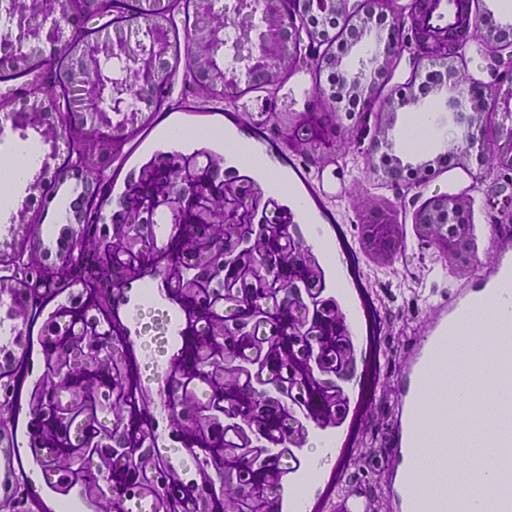

In [28]:
plot_annotated_image(tiles_dicts[1000])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>0870e4f9d580</code>. In the polygons.jsonl list, this tile has an index of <i>50</i>.</p>

In [29]:
tiles_dicts[50]["id"]

'0870e4f9d580'

In [30]:
len(tiles_dicts)

1633

In [31]:
tile_meta_df[tile_meta_df.id == "0870e4f9d580"]

,id,source_wsi,dataset,i,j
253,0870e4f9d580,2,2,24576,23040



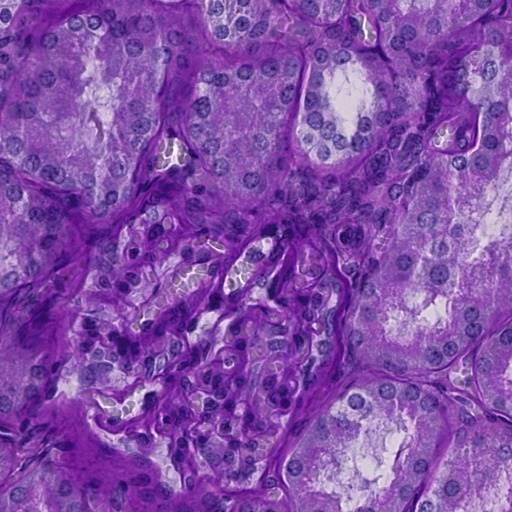

In [32]:
plot_annotated_image(tiles_dicts[50])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>0033bbc76b6b</code>. In the polygons.jsonl list, this tile has an index of <i>2</i>.</p>

In [33]:
tiles_dicts[2]["id"]

'0033bbc76b6b'

In [34]:
tile_meta_df[tile_meta_df.id == "0033bbc76b6b"]

,id,source_wsi,dataset,i,j
4,0033bbc76b6b,1,1,10240,43008



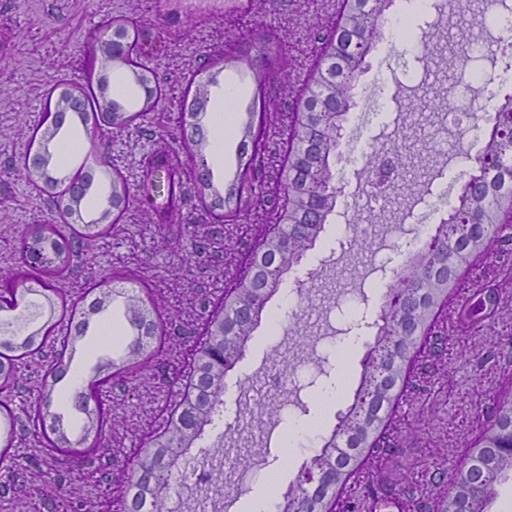

In [35]:
plot_annotated_image(tiles_dicts[2])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>4ca084aec87b</code>. In the polygons.jsonl list, this tile has an index of <i>500</i>.</p>

In [36]:
tiles_dicts[0]["id"]

'0006ff2aa7cd'

In [37]:
tile_meta_df[tile_meta_df.id == "0006ff2aa7cd"]

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420



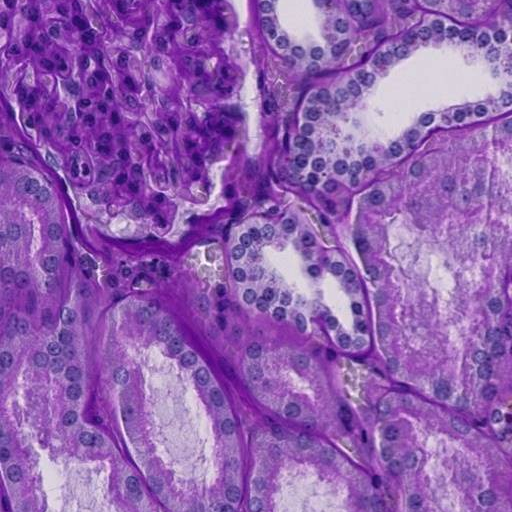

In [38]:
plot_annotated_image(tiles_dicts[0])

<a id="1.5"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.5 Further plan</b></div>

1. Look into open source image models to use.
2. Choose between fine tuning or training model from scratch.
3. Choose model architechture / fine tune an open source image model to identify Type 2 (glomerulus). (Model 1)
4. Do a proper train/test split.
    a. Test dataset needs to contain Dataset 1 tyles only.
5. Add meta data to Model 1.
6. Using same logic as 3-5, train a model to identify Type 1 (blood vessels - target). (Model 2)
7. Combine both models for final predictions (a blood vessel in glomerulus is a FP).
8. Look for ways to use Dataset 3 (unmarked dataset).
    *     https://journalofbigdata.springeropen.com/articles/10.1186/s40537-023-00727-2#Sec19 - Self-supervised learning
    *     https://github.com/HiLab-git/SSL4MIS - Semi-supervised learning

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Part 2 - Building Model 1 & 2</center>

Using https://github.com/PaddlePaddle/PaddleSeg

<a id="2.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.1 Install PaddlePaddle</b></div>

In [34]:
#Using CPU version for now
# !python -m pip install paddlepaddle==2.4.2 -i https://pypi.tuna.tsinghua.edu.cn/simple
# !python -m pip install paddlepaddle==2.4.2 --no-index --find-links=file:///kaggle/input/libraries2/libraries/paddlepaddle 
os.system("python -m pip install paddlepaddle==2.4.2 --no-index --find-links=file:///kaggle/input/libraries2/libraries/paddlepaddle ")

# Switch to GPU version for speed later
# !pip install paddlepaddle-gpu==2.4.2 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in links: file:///kaggle/input/libraries2/libraries/paddlepaddle
Processing /kaggle/input/libraries2/libraries/paddlepaddle/paddlepaddle-2.4.2-cp310-cp310-manylinux1_x86_64.whl
Processing /kaggle/input/libraries2/libraries/paddlepaddle/astor-0.8.1-py2.py3-none-any.whl
Processing /kaggle/input/libraries2/libraries/paddlepaddle/paddle_bfloat-0.1.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/libraries2/libraries/paddlepaddle/protobuf-3.20.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
grpc-google-iam-v1 0.12.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
googleapis-common-protos 1.59.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5

0

In [35]:
import paddle
# paddle.utils.run_check()

Install PaddleSeg

In [36]:
# !git clone https://github.com/PaddlePaddle/PaddleSeg
# !cp -r /kaggle/input/paddleseggithub /kaggle/working/PaddleSeg/
shutil.copytree("/kaggle/input/paddleseggithub", "/kaggle/working/PaddleSeg/")

'/kaggle/working/PaddleSeg/'

In [37]:
# !pip install -r PaddleSeg/requirements.txt
# !pip install -r PaddleSeg/requirements.txt --no-index --find-links=file:///kaggle/input/libraries2/libraries/requirements 
os.system("pip install -r PaddleSeg/requirements.txt --no-index --find-links=file:///kaggle/input/libraries2/libraries/requirements ")

Looking in links: file:///kaggle/input/libraries2/libraries/requirements
Processing /kaggle/input/libraries2/libraries/requirements/visualdl-2.5.3-py3-none-any.whl
Processing /kaggle/input/libraries2/libraries/requirements/bce_python_sdk-0.8.87-py3-none-any.whl
Processing /kaggle/input/libraries2/libraries/requirements/rarfile-4.0-py3-none-any.whl
Processing /kaggle/input/libraries2/libraries/requirements/flask_babel-3.1.0-py3-none-any.whl


0

In [38]:
# !pip install -v -e PaddleSeg/. 
# !pip install -v -e PaddleSeg/. --no-index --find-links=file:///kaggle/input/libraries2/libraries/setup 
os.system("pip install -v -e PaddleSeg/. --no-index --find-links=file:///kaggle/input/libraries2/libraries/setup")

Using pip 23.0.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
Looking in links: file:///kaggle/input/libraries2/libraries/setup
Obtaining file:///kaggle/working/PaddleSeg
  Preparing metadata (setup.py): started


  Running command python setup.py egg_info
  /opt/conda/lib/python3.10/distutils/command/install.py:13: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
    from distutils.sysconfig import get_config_vars
  /opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
    warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
  /kaggle/working/PaddleSeg/paddleseg/models/layers/ms_deformable_attention.py:95: DeprecationWarning: invalid escape sequence '\s'
    """
  /kaggle/working/PaddleSeg/paddleseg/models/losses/rmi_loss.py:73: DeprecationWarning: invalid escape sequence '\i'
    """
  running egg_info
  creating /tmp/pip-pip-egg-info-vocu63zq/paddleseg.egg-info
  writing /tmp/pip-pip-egg-info-vocu63zq/paddleseg.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-vocu63zq/paddleseg.egg-info/dependen

  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for paddleseg


    Running command python setup.py develop
    /opt/conda/lib/python3.10/distutils/command/install.py:13: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
      from distutils.sysconfig import get_config_vars
    /opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
      warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
    running develop
    /opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
      warnings.warn(
    /opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
      warnings.warn(
    running egg_info
    creating padd

0

In [39]:
# !pip install paddleseg
# !pip install paddleseg --no-index --find-links=file:///kaggle/input/libraries2/libraries/paddleseg 
os.system("pip install paddleseg --no-index --find-links=file:///kaggle/input/libraries2/libraries/paddleseg ")

Looking in links: file:///kaggle/input/libraries2/libraries/paddleseg


0

In [40]:
# To use PaddleSeg, change working directory
os.chdir("/kaggle/working/PaddleSeg")
# Check everything is installed correctly
# !sh tests/install/check_predict.sh

<a id="2.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.2 Prepare data</b></div>

https://github.com/PaddlePaddle/PaddleSeg/blob/release/2.8/docs/data/marker/marker.md

In [41]:
# Expected data structure:
# custom_dataset
#     |
#     |--images
#     |  |--image1.jpg
#     |  |--image2.jpg
#     |  |--...
#     |
#     |--labels
#     |  |--label1.png
#     |  |--label2.png
#     |  |--...
#     |
#     |--train.txt
#     |
#     |--val.txt
#     |
#     |--test.txt

# label1, etc. are png images with 0 for background, 1 for class

In [42]:
# # Load standard dataset for data format reference
# !mkdir disc_data
# os.chdir("/kaggle/working/PaddleSeg/disc_data")
# !wget https://paddleseg.bj.bcebos.com/dataset/optic_disc_seg.zip
# !unzip optic_disc_seg.zip
# os.chdir("/kaggle/working/PaddleSeg")


In [43]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/disc_data/optic_disc_seg/Annotations/P0065.png')
# plt.imshow(img,cmap='Greys')
# plt.show()


In [44]:
# with open("/kaggle/working/PaddleSeg/disc_data/optic_disc_seg/test_list.txt") as file:
#     print(file.read())

Data conversion: 
1. Save labeled images as jpg in custom_dataset/images/image1.jpg
2. Convert labels for Type 1 in png images and save in custom_dataset/labels/label1.jpg
3. Generate txt files

In [45]:
# # All polygons are in tiles_dicts. 
# # Only images with ids in tiles_dicts[]["id"] need to be injested for now as those are the only annotated ones
# # Polygons with 'annotations': 'type': 'glomerulus' need to be filled for the label images

# with open('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl', 'r') as json_file:
#     json_list = list(json_file)
    
# tiles_dicts = []
# for json_str in json_list:
#     tiles_dicts.append(json.loads(json_str))

In [46]:
# Create required folders
folder_name = "glomerulus_dataset"
if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}"):
    os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}")
if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}/images"):
    os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}/images")
if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}/labels"):
    os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}/labels")
    

In [47]:
# def save_tiff_as_jpg(image_dict, path) -> None:
#     array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
#     img_example = Image.fromarray(array)
#     path = path + f'image_{image_dict["id"]}.jpg'
#     img_example.save(path)

In [48]:
# def save_polygon_as_png(image_dict, path, target_type = 'glomerulus') -> None:

#     array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
#     img_example = Image.fromarray(array)

#     annotations = image_dict["annotations"]

#     # constants
#     img_width = img_example.size[0]
#     img_height = img_example.size[1]

#     # Create empty array
#     img_array = np.zeros((img_width, img_height, 4), dtype='float32') 
#     for i in range(img_width):
#         for j in range(img_height):
#             img_array[i][j][3]=255

#         # add polygons
#         for annotation in annotations:
#             name = annotation["type"]
#             if name == target_type:
#                 xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
#                 contours = np.column_stack(get_cartesian_coords(annotation["coordinates"], img_height))
#                 cv2.fillPoly(img_array, pts =[contours], color=(128,0,0,255))

#     path = path + f'{target_type}_{image_dict["id"]}.png'

#     # Save the image
#     array_to_save = np.flip(img_array, axis=0)
#     im = Image.fromarray(array_to_save.astype(np.uint8))
#     im.convert('P').save(path, "PNG")


In [49]:
# tile_meta_df['dataset'].hist()

In [50]:
# base_path = "/kaggle/working/PaddleSeg/glomerulus_dataset/"
# path_images = "images/"
# path_labels = "labels/"
# target_type = 'glomerulus'

# files = ['train.txt', 'test.txt', 'val.txt']

# for tile in tiles_dicts:
#     # Save annotated images in custom_dataset/images
#     save_tiff_as_jpg(tile, base_path + path_images)
#     # Save labels as png in custom_dataset/labels
#     save_polygon_as_png(tile, base_path + path_labels, target_type)
    
#     # Save txt description files
#     # First, determine source dataset
#     dataset_id = tile_meta_df[tile_meta_df.id == tile["id"]]['dataset'].values 
#     # All of dataset 2 is assigned to train
#     # Dataset 1 is split 1:1:1 in train, test and val
#     text = path_images + f'image_{tile["id"]}.jpg' + ' ' + path_labels + f'{target_type}_{tile["id"]}.png \n'
    
#     if dataset_id == 2:
#         # All of dataset 2 is assigned to train
#         with open(base_path + 'train.txt', 'a') as f:
#             f.write(text)
#     else:
#         # Dataset 1 is split 1:1:1 in train, test and val
#         with open(base_path + random.choice(files), 'a') as f:
#             f.write(text)

In [51]:
# os.chdir("/kaggle/working/PaddleSeg/glomerulus_dataset/images")
# !ls
# os.chdir("/kaggle/working/PaddleSeg")


In [52]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_dataset/images/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [53]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_dataset/labels/glomerulus_0006ff2aa7cd.png')
# plt.imshow(img,cmap='Greys')
# plt.show()

In [54]:
# with open("/kaggle/working/PaddleSeg/glomerulus_dataset/val.txt") as file:
#     print(file.read())

<a id="2.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.3 Prepare Config File</b></div>

In [55]:
# os.chdir("/kaggle/working/PaddleSeg/disc_data/optic_disc_seg")
# !ls
# os.chdir("/kaggle/working/PaddleSeg")


In [56]:
# os.chdir("/kaggle/working/PaddleSeg/glomerulus_dataset/")
# with open('labels.txt', 'w') as f:
#     f.write("background\n")
#     f.write("glomerulus")
# # !ls
# os.chdir("/kaggle/working/PaddleSeg")


In [57]:
# with open("/kaggle/working/PaddleSeg/glomerulus_dataset/labels.txt") as file:
#     print(file.read())

In [58]:
# os.chdir("/kaggle/working/PaddleSeg/configs/")

# if not os.path.exists("/kaggle/working/PaddleSeg/configs/glomerulus_dataset"):
#     os.mkdir("/kaggle/working/PaddleSeg/configs/glomerulus_dataset")
    
# os.chdir("/kaggle/working/PaddleSeg/configs/glomerulus_dataset/")

# with open('glomerulus_config_512x512_1k.yml', 'w') as f:
#     f.write("batch_size: 4\n")
#     f.write("iters: 1000\n")
#     f.write("\n")
#     f.write("train_dataset:\n")
#     f.write("  type: Dataset\n")
#     f.write("  dataset_root: glomerulus_dataset\n")
#     f.write("  train_path: glomerulus_dataset/train.txt\n")
#     f.write("  num_classes: 2\n")
#     f.write("  mode: train\n")
#     f.write("  transforms:\n    - type: ResizeStepScaling\n      min_scale_factor: 0.5\n      max_scale_factor: 2.0\n      scale_step_size: 0.25\n    - type: RandomPaddingCrop\n      crop_size: [512, 512]\n    - type: RandomHorizontalFlip\n    - type: RandomDistort\n      brightness_range: 0.5\n      contrast_range: 0.5\n      saturation_range: 0.5\n    - type: Normalize\n")
#     f.write("\n")
#     f.write("val_dataset:\n")
#     f.write("  type: Dataset\n")
#     f.write("  dataset_root: glomerulus_dataset\n")
#     f.write("  val_path: glomerulus_dataset/val.txt\n")
#     f.write("  num_classes: 2\n")
#     f.write("  mode: val\n")
#     f.write("  transforms:\n    - type: Normalize\n")
#     f.write("\n")
#     f.write("optimizer:\n  type: SGD\n  momentum: 0.9\n  weight_decay: 4.0e-5\n\n")
#     f.write("lr_scheduler:\n  type: PolynomialDecay\n  learning_rate: 0.01\n  end_lr: 0\n  power: 0.9\n\n")
#     f.write("loss:\n  types:\n    - type: CrossEntropyLoss\n  coef: [1, 1, 1]\n\n")
#     f.write("model:\n  type: PPLiteSeg\n  backbone:\n    type: STDC2\n    pretrained: https://bj.bcebos.com/paddleseg/dygraph/PP_STDCNet2.tar.gz\n\n")
    
# # !ls
# os.chdir("/kaggle/working/PaddleSeg")

In [59]:
# with open("/kaggle/working/PaddleSeg/configs/glomerulus_dataset/glomerulus_config_512x512_1k.yml") as file:
#     print(file.read())

In [60]:
# with open("/kaggle/working/PaddleSeg/configs/quick_start/pp_liteseg_optic_disc_512x512_1k.yml") as file:
#     print(file.read())

<a id="2.4"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.4 Train Model 1</b></div>

In [61]:
# # !export CUDA_VISIBLE_DEVICES=0 # Set 1 usable card

# !python tools/train.py \
#         --config configs/glomerulus_dataset/glomerulus_config_512x512_1k.yml \
#         --do_eval \
#         --use_vdl \
#         --save_interval 500 \
#         --save_dir output

In [62]:
# # Export the model
# !python tools/export.py \
#        --config configs/glomerulus_dataset/glomerulus_config_512x512_1k.yml \
#        --model_path output/iter_1000/model.pdparams

In [63]:
# Save all files / trained model
# os.chdir("/kaggle/working/PaddleSeg")
# zip_dir(file_name = 'PaddleSeg.zip')

In [64]:
#Instead of re-training the model, load it from computer in model-folder
# !rm -r /kaggle/working/PaddleSeg/output
# !cp -r /kaggle/input/model-folder/output /kaggle/working/PaddleSeg/
shutil.copytree("/kaggle/input/model-folder/output", "/kaggle/working/PaddleSeg/output")

'/kaggle/working/PaddleSeg/output'

In [65]:
# # Predict and vizualize as an example
# !python tools/predict.py \
#         --config configs/glomerulus_dataset/glomerulus_config_512x512_1k.yml \
#         --model_path output/iter_1000/model.pdparams \
#         --image_path glomerulus_dataset/images/image_0006ff2aa7cd.jpg \
#         --save_dir output/result

In [66]:
# plot_annotated_image(tiles_dicts[0])

In [67]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_dataset/images/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [68]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/output/result/added_prediction/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

<a id="2.5"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 2.5 Model 2</b></div>

In [69]:
# Do same file prep as for model 1

# # Create required folders
# folder_name = "vessel_dataset"
# if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}"):
#     os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}")
# if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}/images"):
#     os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}/images")
# if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}/labels"):
#     os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}/labels")
    
# base_path = f"/kaggle/working/PaddleSeg/{folder_name}/"
# path_images = "images/"
# path_labels = "labels/"
# target_type = 'blood_vessel'

# files = ['train.txt', 'test.txt', 'val.txt']

# for tile in tiles_dicts:
#     # Save annotated images in custom_dataset/images
#     save_tiff_as_jpg(tile, base_path + path_images)
#     # Save labels as png in custom_dataset/labels
#     save_polygon_as_png(tile, base_path + path_labels, target_type)
    
#     # Save txt description files
#     # First, determine source dataset
#     dataset_id = tile_meta_df[tile_meta_df.id == tile["id"]]['dataset'].values 
#     # All of dataset 2 is assigned to train
#     # Dataset 1 is split 1:1:1 in train, test and val
#     text = path_images + f'image_{tile["id"]}.jpg' + ' ' + path_labels + f'{target_type}_{tile["id"]}.png \n'
    
#     if dataset_id == 2:
#         # All of dataset 2 is assigned to train
#         with open(base_path + 'train.txt', 'a') as f:
#             f.write(text)
#     else:
#         # Dataset 1 is split 1:1:1 in train, test and val
#         with open(base_path + random.choice(files), 'a') as f:
#             f.write(text)

In [70]:
# img = mpimg.imread(f'/kaggle/working/PaddleSeg/{folder_name}/images/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [71]:
# img = mpimg.imread(f'/kaggle/working/PaddleSeg/{folder_name}/labels/blood_vessel_0006ff2aa7cd.png')
# plt.imshow(img,cmap='Greys')
# plt.show()

In [72]:
# # Create config file
# os.chdir(f"/kaggle/working/PaddleSeg/{folder_name}/")
# with open('labels.txt', 'w') as f:
#     f.write("background\n")
#     f.write("blood_vessel")
    
# os.chdir("/kaggle/working/PaddleSeg/configs/")

# if not os.path.exists(f"/kaggle/working/PaddleSeg/configs/{folder_name}"):
#     os.mkdir(f"/kaggle/working/PaddleSeg/configs/{folder_name}")
    
# os.chdir(f"/kaggle/working/PaddleSeg/configs/{folder_name}/")

# with open('vessel_config_512x512_1k.yml', 'w') as f:
#     f.write("batch_size: 4\n")
#     f.write("iters: 1000\n")
#     f.write("\n")
#     f.write("train_dataset:\n")
#     f.write("  type: Dataset\n")
#     f.write(f"  dataset_root: {folder_name}\n")
#     f.write(f"  train_path: {folder_name}/train.txt\n")
#     f.write("  num_classes: 2\n")
#     f.write("  mode: train\n")
#     f.write("  transforms:\n    - type: ResizeStepScaling\n      min_scale_factor: 0.5\n      max_scale_factor: 2.0\n      scale_step_size: 0.25\n    - type: RandomPaddingCrop\n      crop_size: [512, 512]\n    - type: RandomHorizontalFlip\n    - type: RandomDistort\n      brightness_range: 0.5\n      contrast_range: 0.5\n      saturation_range: 0.5\n    - type: Normalize\n")
#     f.write("\n")
#     f.write("val_dataset:\n")
#     f.write("  type: Dataset\n")
#     f.write(f"  dataset_root: {folder_name}\n")
#     f.write(f"  val_path: {folder_name}/val.txt\n")
#     f.write("  num_classes: 2\n")
#     f.write("  mode: val\n")
#     f.write("  transforms:\n    - type: Normalize\n")
#     f.write("\n")
#     f.write("optimizer:\n  type: SGD\n  momentum: 0.9\n  weight_decay: 4.0e-5\n\n")
#     f.write("lr_scheduler:\n  type: PolynomialDecay\n  learning_rate: 0.01\n  end_lr: 0\n  power: 0.9\n\n")
#     f.write("loss:\n  types:\n    - type: CrossEntropyLoss\n  coef: [1, 1, 1]\n\n")
#     f.write("model:\n  type: PPLiteSeg\n  backbone:\n    type: STDC2\n    pretrained: https://bj.bcebos.com/paddleseg/dygraph/PP_STDCNet2.tar.gz\n\n")
    
# # !ls
# os.chdir("/kaggle/working/PaddleSeg")

In [73]:
# # Train the model
# !python tools/train.py \
#         --config configs/vessel_dataset/vessel_config_512x512_1k.yml \
#         --do_eval \
#         --use_vdl \
#         --save_interval 500 \
#         --save_dir vessel_output

In [74]:
# # Export the model
# !python tools/export.py \
#        --config configs/vessel_dataset/vessel_config_512x512_1k.yml \
#        --model_path vessel_output/iter_1000/model.pdparams

In [75]:
#Instead of re-training the model, load it from computer in model-folder
# !rm -r /kaggle/working/PaddleSeg/vessel_output
# !cp -r /kaggle/input/vessel-folder/vessel_output /kaggle/working/PaddleSeg/
shutil.copytree("/kaggle/input/vessel-folder/vessel_output", "/kaggle/working/PaddleSeg/vessel_output")

'/kaggle/working/PaddleSeg/vessel_output'

In [76]:
#Instead of re-training the model, load it from computer in model-folder
# !cp -r /kaggle/input/vessel-inference/vessel_inference /kaggle/working/PaddleSeg/vessel_output
shutil.copytree("/kaggle/input/vessel-inference/vessel_inference", "/kaggle/working/PaddleSeg/vessel_output/vessel_inference")

'/kaggle/working/PaddleSeg/vessel_output/vessel_inference'

In [77]:
# # Predict and vizualize as an example
# !python tools/predict.py \
#         --config configs/vessel_dataset/vessel_config_512x512_1k.yml \
#         --model_path vessel_output/iter_1000/model.pdparams \
#         --image_path vessel_dataset/images/image_0006ff2aa7cd.jpg \
#         --save_dir vessel_output/result

In [78]:
# plot_annotated_image(tiles_dicts[0])

In [79]:
# img = mpimg.imread(f'/kaggle/working/PaddleSeg/{folder_name}/images/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [80]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/vessel_output/result/added_prediction/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [81]:
# # # Save trained model
# os.chdir("/kaggle/working")
# # zip_dir(file_name = 'vessel_output.zip')
# !zip -r PaddleSeg.zip "/kaggle/working/PaddleSeg"
# os.chdir("/kaggle/working/PaddleSeg")

In [82]:
# # Save inference model
# os.chdir("/kaggle/working/PaddleSeg/output/inference_model")
# zip_dir(file_name = 'vessel_inference.zip')
# !zip -r vessel_inference.zip "/kaggle/working/PaddleSeg/output/inference_model"

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Part 3 - Model deployment</center>


<a id="3.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.1 Deploy Models 1 & 2</b></div>

In [83]:
def save_test_tiff_as_jpg(input_path, output_path) -> None:
    array = tiff.imread(input_path)
    img_example = Image.fromarray(array)
    file_id = input_path.split('/')[-1].split('.')[0]
    output_path = output_path + f'image_{file_id}.jpg'
    img_example.save(output_path)

In [84]:
# Save test dataset in the same format

# Create required folders
folder_name = "test_dataset"
if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}"):
    os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}")
if not os.path.exists(f"/kaggle/working/PaddleSeg/{folder_name}/images"):
    os.mkdir(f"/kaggle/working/PaddleSeg/{folder_name}/images")
    
base_path = f"/kaggle/working/PaddleSeg/{folder_name}/"
path_images = "images/"

# n=0
for file in glob.glob("/kaggle/input/hubmap-hacking-the-human-vasculature/test/*.tif"):
    # Save annotated images in folder_name/images
    save_test_tiff_as_jpg(file, base_path + path_images)
#     n=n+1
#     if n==50:
#         break


In [85]:
# !rm -r /kaggle/working/PaddleSeg/test_dataset/images
# !rm -r /kaggle/working/PaddleSeg/glomerulus_output
# !rm -r /kaggle/working/PaddleSeg/vessel_output
# !rm -r /kaggle/working/PaddleSeg/combined_output

In [86]:
# os.chdir("/kaggle/working/PaddleSeg/test_dataset/images")
# !ls
# os.chdir("/kaggle/working/PaddleSeg")

In [87]:
# # Predict and vizualize as an example
# !python tools/predict.py \
#         --config configs/glomerulus_dataset/glomerulus_config_512x512_1k.yml \
#         --model_path output/iter_1000/model.pdparams \
#         --image_path test_dataset/images/image_0006ff2aa7cd.jpg \
#         --save_dir glomerulus_output/result

In [88]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_output/result/added_prediction/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [89]:
# Deploy Model 1
# !python deploy/python/infer.py \
# --config output/inference_model/deploy.yaml\
# --image_path test_dataset/images/\
# --save_dir glomerulus_output

os.chdir("/kaggle/working/PaddleSeg")
os.system("python deploy/python/infer.py --config output/inference_model/deploy.yaml --image_path test_dataset/images/ --save_dir glomerulus_output")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-08-02 15:03:17 [INFO]	Use GPU


E0802 15:03:17.433213   151 analysis_config.cc:110] Please use PaddlePaddle with GPU version.
--- Running analysis [ir_graph_build_pass]
--- Running analysis [ir_analysis_pass]
--- Running IR pass [simplify_with_basic_ops_pass]
--- Running IR pass [layer_norm_fuse_pass]
---    Fused 0 subgraphs into layer_norm op.
--- Running IR pass [attention_lstm_fuse_pass]
--- Running IR pass [seqconv_eltadd_relu_fuse_pass]
--- Running IR pass [seqpool_cvm_concat_fuse_pass]
--- Running IR pass [mul_lstm_fuse_pass]
--- Running IR pass [fc_gru_fuse_pass]
---    fused 0 pairs of fc gru patterns
--- Running IR pass [mul_gru_fuse_pass]
--- Running IR pass [seq_concat_fc_fuse_pass]
--- Running IR pass [gpu_cpu_squeeze2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_reshape2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_flatten2_matmul_fuse_pass]
--- Running IR pass [matmul_v2_scale_fuse_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_mul_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_matmul_pas

2023-08-02 15:03:18 [INFO]	Finish


0

In [90]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_output/image_72e40acccadf.png')
# imgplot = plt.imshow(img)
# plt.show()

In [91]:
# # test deployment of model 2
# # Predict and vizualize as an example
# !python tools/predict.py \
#         --config configs/vessel_dataset/vessel_config_512x512_1k.yml \
#         --model_path vessel_output/iter_1000/model.pdparams \
#         --image_path test_dataset/images/image_0006ff2aa7cd.jpg \
#         --save_dir vessel_output/result

In [92]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/vessel_output/result/added_prediction/image_0006ff2aa7cd.jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [93]:
# Deploy Model 2
# !python deploy/python/infer.py \
# --config vessel_output/vessel_inference/deploy.yaml\
# --image_path test_dataset/images/\
# --save_dir vessel_output

os.system("python deploy/python/infer.py --config vessel_output/vessel_inference/deploy.yaml --image_path test_dataset/images/ --save_dir vessel_output")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-08-02 15:03:21 [INFO]	Use GPU


E0802 15:03:21.127244   165 analysis_config.cc:110] Please use PaddlePaddle with GPU version.
--- Running analysis [ir_graph_build_pass]
--- Running analysis [ir_analysis_pass]
--- Running IR pass [simplify_with_basic_ops_pass]
--- Running IR pass [layer_norm_fuse_pass]
---    Fused 0 subgraphs into layer_norm op.
--- Running IR pass [attention_lstm_fuse_pass]
--- Running IR pass [seqconv_eltadd_relu_fuse_pass]
--- Running IR pass [seqpool_cvm_concat_fuse_pass]
--- Running IR pass [mul_lstm_fuse_pass]
--- Running IR pass [fc_gru_fuse_pass]
---    fused 0 pairs of fc gru patterns
--- Running IR pass [mul_gru_fuse_pass]
--- Running IR pass [seq_concat_fc_fuse_pass]
--- Running IR pass [gpu_cpu_squeeze2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_reshape2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_flatten2_matmul_fuse_pass]
--- Running IR pass [matmul_v2_scale_fuse_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_mul_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_matmul_pas

2023-08-02 15:03:22 [INFO]	Finish


0

In [94]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/vessel_output/image_72e40acccadf.png')
# imgplot = plt.imshow(img)
# plt.show()

<a id="3.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 3.2 Combine predictions of two models </b></div>

In [95]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/glomerulus_output/image_72e40acccadf.png')
# imgplot = plt.imshow(img)
# plt.show()

In [96]:
if not os.path.exists(f"/kaggle/working/PaddleSeg/combined_output"):
    os.mkdir(f"/kaggle/working/PaddleSeg/combined_output")

In [97]:
# Convert Model 1 predictions to masks and apply mask to Model 2 predictions 
for file in glob.glob("/kaggle/working/PaddleSeg/test_dataset/images/*.jpg"):

    file_name = file.split('/')[-1].split('.')[0]
    glomerulus_img = cv2.imread(f'/kaggle/working/PaddleSeg/glomerulus_output/{file_name}.png', cv2.IMREAD_GRAYSCALE) 
    glomerulus_img = np.flip(glomerulus_img, axis=0)
    glomerulus_mask = np.column_stack(np.where(np.transpose(glomerulus_img) > 38))

    vessel_img = cv2.imread(f'/kaggle/working/PaddleSeg/vessel_output/{file_name}.png', cv2.IMREAD_GRAYSCALE)

    # constants
    img_width = 512
    img_height = 512

    contour = np.column_stack(get_cartesian_coords(glomerulus_mask, img_height))
    if len(glomerulus_mask)!=0:
        cv2.fillPoly(vessel_img, pts =[contour], color=38)

    # Save the image
    output_path = '/kaggle/working/PaddleSeg/combined_output/' + f'{file_name}.png'
    im = Image.fromarray(vessel_img.astype(np.uint8))
    im.save(output_path)
    im.convert('P').save(output_path, "PNG")


In [98]:
# os.chdir("/kaggle/working/PaddleSeg/combined_output/")
# !ls
# os.chdir("/kaggle/working/PaddleSeg")

In [99]:
# img = mpimg.imread('/kaggle/working/PaddleSeg/combined_output/image_76cc32c629e9.png')
# imgplot = plt.imshow(img)
# plt.show()

In [100]:
# # Convert combined predictions to binary mask
# binary_mask = cv2.imread(f'/kaggle/working/PaddleSeg/combined_output/image_72e40acccadf.png', cv2.IMREAD_GRAYSCALE) 
# binary_mask[binary_mask == 38] = False
# binary_mask[binary_mask == 75] = True
# binary_mask = binary_mask.astype(bool)
# binary_mask

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Part 4 - Submission</center>

In [101]:
# !pip install pycocotools
shutil.copytree("/kaggle/input/pycocotools/pycocotools/pycocotools", "/kaggle/working/packages")
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
os.system("python setup.py install")
os.system("pip install . --no-index --find-links /kaggle/working/packages/")
os.chdir("/kaggle/working")
# !pip install pycocotools --no-index --find-links=file:///kaggle/input/pycocotools/pycocotools/pycocotools/pycocotools-2.0.6

running install


/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
creating build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.10/pycocotools
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c


/opt/conda/lib/python3.10/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/packages/pycocotools-2.0.6/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


building 'pycocotools._mask' extension
creating build/temp.linux-x86_64-3.10
creating build/temp.linux-x86_64-3.10/common
creating build/temp.linux-x86_64-3.10/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC -I/opt/conda/lib/python3.10/site-packages/numpy/core/include -I./common -I/opt/conda/include/python3.10 -c ./common/maskApi.c -o build/temp.linux-x86_64-3.10/./common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99


./common/maskApi.c: In function ‘rleToBbox’:
./common/maskApi.c:151:32: warning: unused variable ‘xp’ [-Wunused-variable]
  151 |     uint h, w, xs, ys, xe, ye, xp, cc; siz j, m;
      |                                ^~
./common/maskApi.c: In function ‘rleFrPoly’:
./common/maskApi.c:197:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |   ^~~
./common/maskApi.c:197:54: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |                                                      ^
./common/maskApi.c:198:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
  198 |   for(j=0; j<k; j++) y[j]=(int)(scale*xy[j*2+1]+.5); y[k]=y[0];
      |   ^~~
./common/maskApi.c:198:54: note: ...this statement, but the latter is misleadingly indented as if it wer

gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC -I/opt/conda/lib/python3.10/site-packages/numpy/core/include -I./common -I/opt/conda/include/python3.10 -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.10/pycocotools/_mask.o -Wno-cpp -Wno-unused-function -std=c99


pycocotools/_mask.c: In function ‘__pyx_pf_11pycocotools_5_mask_12iou’:
pycocotools/_mask.c:6140:31: warning: comparison of integer expressions of different signedness: ‘Py_ssize_t’ {aka ‘long int’} and ‘siz’ {aka ‘long unsigned int’} [-Wsign-compare]
 6140 |     if (unlikely(!((__pyx_t_8 == __pyx_v_n) != 0))) {
      |                               ^~
pycocotools/_mask.c:944:43: note: in definition of macro ‘unlikely’
  944 |   #define unlikely(x) __builtin_expect(!!(x), 0)
      |                                           ^


gcc -pthread -B /opt/conda/compiler_compat -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib build/temp.linux-x86_64-3.10/./common/maskApi.o build/temp.linux-x86_64-3.10/pycocotools/_mask.o -o build/lib.linux-x86_64-3.10/pycocotools/_mask.cpython-310-x86_64-linux-gnu.so
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/_mask.cpython-310-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying

zip_safe flag not set; analyzing archive contents...
pycocotools.__pycache__._mask.cpython-310: module references __file__


Searching for numpy==1.23.5
Best match: numpy 1.23.5
Adding numpy 1.23.5 to easy-install.pth file
Installing f2py script to /opt/conda/bin
Installing f2py3 script to /opt/conda/bin
Installing f2py3.10 script to /opt/conda/bin

Using /opt/conda/lib/python3.10/site-packages
Searching for matplotlib==3.6.3
Best match: matplotlib 3.6.3
Adding matplotlib 3.6.3 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for contourpy==1.0.7
Best match: contourpy 1.0.7
Adding contourpy 1.0.7 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for kiwisolver==1.4.4
Best match: kiwisolver 1.4.4
Adding kiwisolver 1.4.4 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for pyparsing==3.0.9
Best match: pyparsing 3.0.9
Adding pyparsing 3.0.9 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for fonttools==4.39.3
Best match: fonttools 4.39.3
Adding fonttools 4.39.3 to easy-install.pth 

In [102]:
# if not os.path.exists(f"/kaggle/working/libraries"):
#     os.mkdir(f"/kaggle/working/libraries")
os.chdir("/kaggle/working/")
# Download all required libraries
# !pip download kaleido -d ./kaleido/

# #Using CPU version for now
# !python -m pip download paddlepaddle==2.4.2 -i https://pypi.tuna.tsinghua.edu.cn/simple -d ./paddlepaddle/

# !pip download -r /kaggle/working/PaddleSeg/requirements.txt -d ./requirements/
# !pip download -v /kaggle/working/PaddleSeg/. -d ./setup/

# !pip download paddleseg -d ./paddleseg/

# !pip download pycocotools -d ./pycocotools/

In [103]:
# os.chdir("/kaggle/working")
# # # zip_dir(file_name = 'libraries.zip')
# !zip -r libraries.zip "/kaggle/working/libraries"
# os.chdir("/kaggle/working/PaddleSeg")


In [104]:
# Submission functions
import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

In [105]:
# # TODO: this might not be correct, because it is expected that each mask is encoded separately, e.g.:  0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA== 0 0.5 eAndnnDS1A/mdmkE35Ek9d
# encode_binary_mask(binary_mask)

In [106]:
from scipy import ndimage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [107]:
def create_separate_masks(img):
    
    string_start = "0 1.0 "
    string_con = " 0 1.0 "
    
    height = 512
    width = 512

    mask = img != np.array([38, 38, 38]).astype('uint8')
    mask = mask[:, :, 0]  # Take the first channel for RGB images

    # Connected components
    label_im, nb_labels = ndimage.label(mask)

    if nb_labels > 0:
        separate_masks=[]

        for i in range(nb_labels):

            # create an array which size is same as the mask but filled with 
            # values that we get from the label_im. 
            # If there are three masks, then the pixels are labeled 
            # as 1, 2 and 3.

            mask_compare = np.full(np.shape(label_im), 1) 

            # check equality test and have the value 1 on the location of each mask
            separate_mask = np.equal(label_im, mask_compare).astype(bool) 

            # get the required string
            if i==0:
                prediction_string = string_start + encode_binary_mask(separate_mask).decode('utf-8')
            else:
                prediction_string = prediction_string + string_con + encode_binary_mask(separate_mask).decode('utf-8')

        # update submission_df
        new_row = pd.DataFrame({'id': id,'height': height,'width': width,'prediction_string': prediction_string}, index=[0])
    else:
        fake_mask = mask.astype(bool)
        fake_mask[100][100] = True
        prediction_string = "0 0.1 " + encode_binary_mask(fake_mask).decode('utf-8')
        new_row = pd.DataFrame({'id': id,'height': height,'width': width,'prediction_string': prediction_string}, index=[0])
    
    
    return new_row

In [109]:
# Expected format: csv with following cols
# id,height,width,prediction_string
# 72e40acccadf,512,512,0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA== 0 0.5 eAndnnDS1A/mdmkE35Ek9d

submission_df = pd.DataFrame(columns = ('id','height','width','prediction_string'))

for file in glob.glob("/kaggle/working/PaddleSeg/combined_output/*.png"):
    id = file.split('/')[-1].split('.')[0].split('_')[1]
    # Convert combined predictions to binary mask
    img = cv2.imread(f'/kaggle/working/PaddleSeg/combined_output/image_{id}.png') 
    new_row = create_separate_masks(img)
    submission_df = pd.concat([new_row,submission_df.loc[:]]).reset_index(drop=True)
submission_df = submission_df.set_index('id')
submission_df.to_csv('/kaggle/working/submission.csv')
submission_df.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 1.0 eNrLDMo1s062N/Y18jPyNwRhAwN/QxAJAlDa0B9E...


In [110]:
os.system("rm -r /kaggle/working/PaddleSeg/")

0